In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizerFast
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import numpy as np
import joblib

# Load validation data
print("Loading dataset...")
df_val = pd.read_csv('../data/validation.csv')
texts = df_val['tweet_text'].tolist()  # Replace 'text' with the name of the column containing the texts
labels = df_val['cyberbullying_type'].tolist()  # Replace 'label' with the name of the column containing the labels

c:\Users\me\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset...


In [2]:
print("Loading label encoder")
le = joblib.load('../models/bert/label_encoder.joblib')

Loading label encoder


In [4]:
# Load the model and tokenizer
print("Loading model...")
model = tf.keras.models.load_model('../models/bert/tf_saved_model/')
print("Loading tokenizer...")
tokenizer = BertTokenizerFast.from_pretrained('../models/bert/tokenizer/')

Loading model...
Loading tokenizer...


In [5]:
# Tokenize the texts
print("Tokenizing...")
val_encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)

Tokenizing...


In [6]:
# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    labels
)).batch(1) # .shuffle(1000).batch(1)

In [7]:
# Use the model to predict the labels
true_labels = []
pred_labels = []

i = 0
for batch in val_dataset:
    inputs, label = batch
    preds = model(inputs)
    preds = tf.argmax(preds['logits'], axis=1)
    true_labels.append(label.numpy()[0].decode('utf-8'))
    pred_labels.append(preds.numpy()[0])

# Compute confusion matrix
conf_matrix = np.array(confusion_matrix(true_labels, le.inverse_transform(pred_labels)))
print(conf_matrix)


[[1568    1    2   19    9    3]
 [   2 1580    1    9    8    4]
 [   2    2 1442   78   67    7]
 [   4    6  120  895  450  113]
 [   5    5  124  314 1071   15]
 [   0    0    7   13    5 1588]]


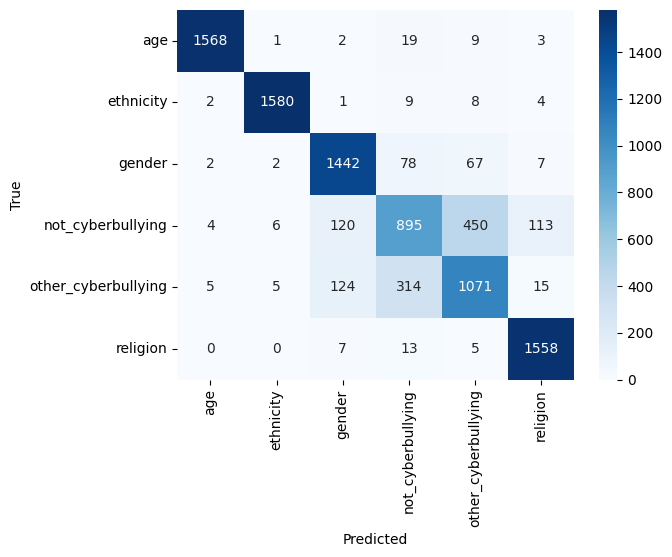

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming that your confusion matrix is stored in the variable conf_matrix
# and your LabelEncoder in the variable le

# Get the class names from the LabelEncoder
class_names = le.classes_

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')

# Add labels to the x and y axis
plt.xlabel('Predicted')
plt.ylabel('True')

# Show the plot
plt.show()

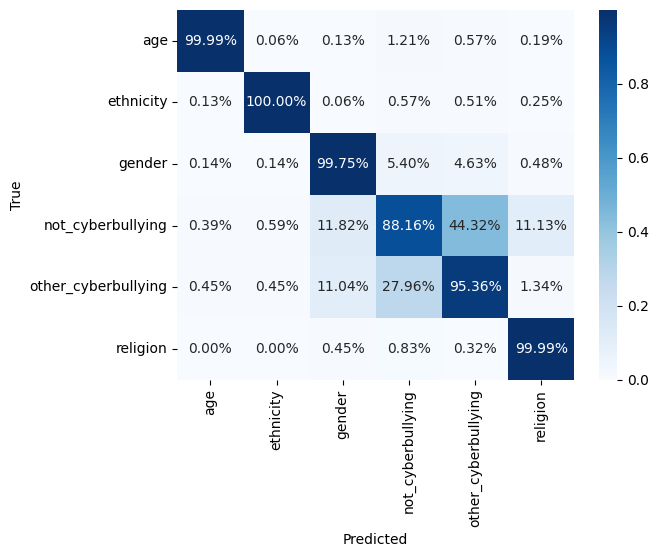

In [12]:
# Normalize array per row
normalized_array = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Create a heatmap
sns.heatmap(normalized_matrix, annot=True, fmt='.2%', xticklabels=class_names, yticklabels=class_names, cmap='Blues')

# Add labels to the x and y axis
plt.xlabel('Predicted')
plt.ylabel('True')

# Show the plot
plt.show()

In [18]:
# Accuracy
tally = 0
total = len(pred_labels)
for i in range(0, total):
	if (true_labels[i] == "not_cyberbullying" and pred_labels[i] == "not_cyberbullying") or \
		(true_labels[i] != "not_cyberbullying" and pred_labels[i] != "not_cyberbullying"):
			tally = tally + 1

print('Bullying accuracy: {:.3%} (bullying or not)'.format(tally/total))

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print('Overall accuracy: {:.3%}'.format(accuracy))

Bullying accuracy: 83.353% (bullying or not)
Overall accuracy: 85.376%
